In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pymc as pm
import xarray as xr
import seaborn as sns
import arviz as az
from scipy import stats as stats
from graphviz import Digraph

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

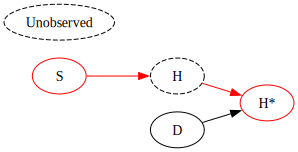

In [3]:
# Create a Digraph object
f = Digraph()
f.attr(rankdir='LR')  # Set graph direction from left to right
f.attr('node', shape='ellipse')  # Set default node shape to circle

# Node styles
f.node("S", color="red")
f.node("H", style="dashed")  # Dashed style for node H
f.node("H*", color="red")
f.node("D", color="black")
f.node("Unobserved", color="black", style="dashed")

# Edge properties
f.edge("S", "H", color="red")  # Red edge from S to
f.edge("H", "H*", color="red")  # Red edge from S to
f.edge("D", "H*", color="black")  # Red edge from S to
f

In [4]:
# Helper function to plot regression line
def plot_regression_line(x, y, color, label, **plot_kwargs):
    valid_idx = ~np.isnan(y)
    
    X = np.vstack((np.ones_like(x[valid_idx]), x[valid_idx])).T
    intercept, slope = np.linalg.lstsq(X, y[valid_idx], rcond=None)[0]
    
    xs = np.linspace(x.min(), x.max(), 10)
    ys = xs * slope + intercept
    plt.plot(xs, ys, color=color, label=label, **plot_kwargs)

# Function to plot dog homework data
def plot_dog_homework(S, H, Hstar, title=None):
    
    # Plot S vs H
    plt.scatter(S, H, color='k', alpha=1, label='total', s=10)
    plot_regression_line(S, H, label='total trend', color='k', alpha=.5)
    
    # Plot S vs Hstar
    plt.scatter(S, Hstar, color='C0', alpha=.8, label='incomplete')
    plot_regression_line(S, Hstar, label='incomplete trend', color='C0', alpha=.5)
    
    # Set labels and title
    plt.xlabel("S")
    plt.ylabel("H")
    if title is not None:
        plt.title(title)
    plt.legend()

    plt.show()  # Display the plot

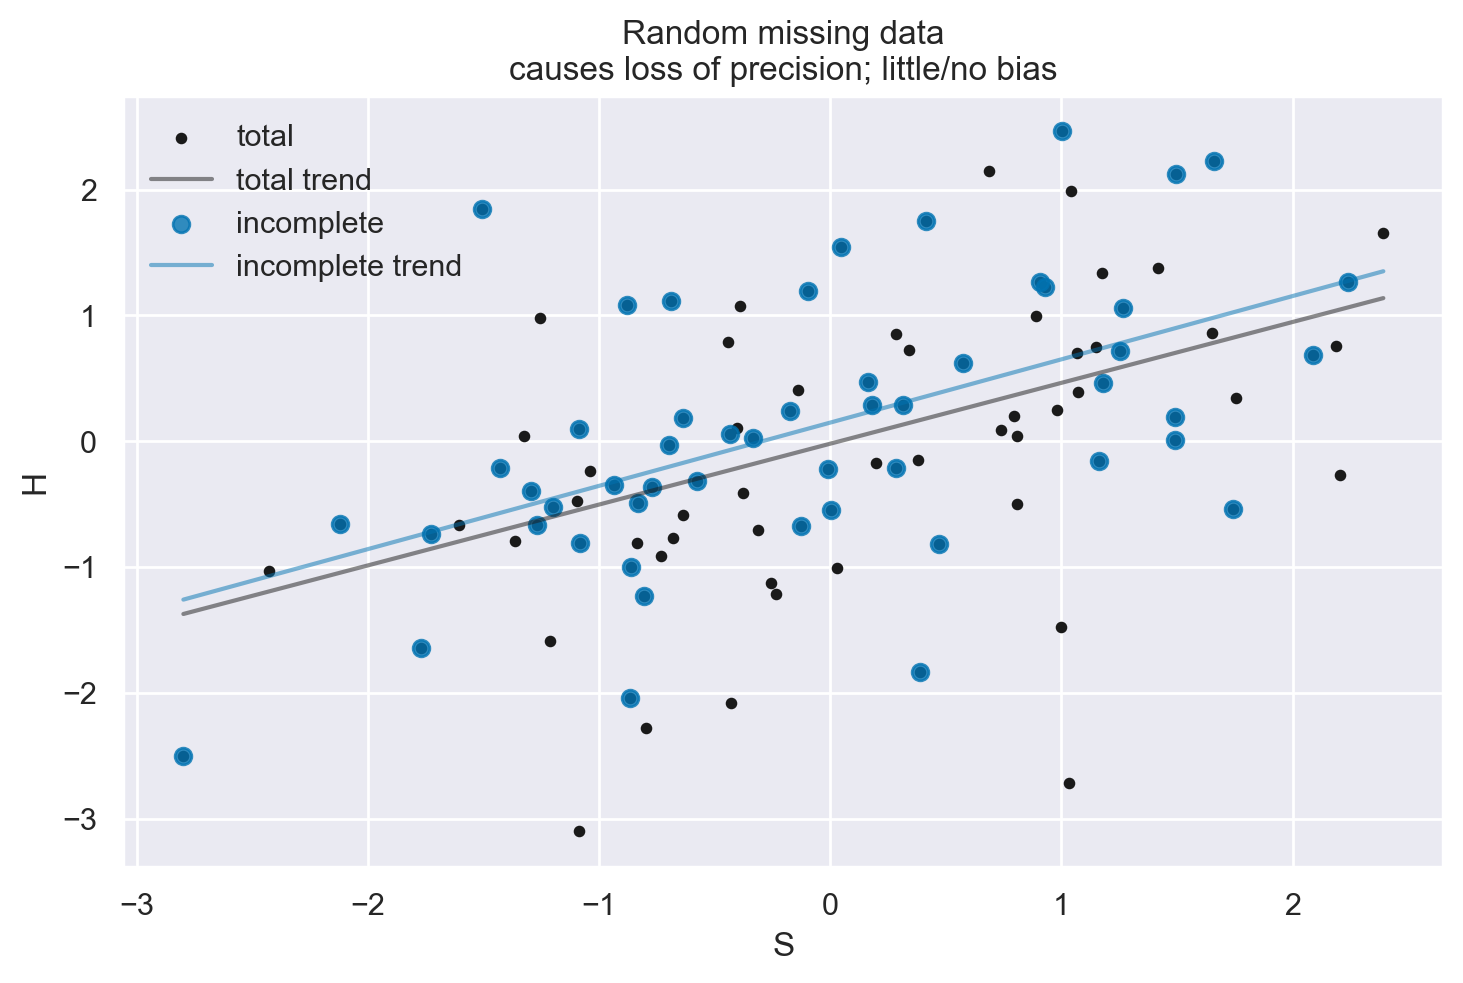

In [5]:
np.random.seed(123)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Homework score
mu_score = S * 0.5
H = stats.norm.rvs(mu_score)

# Dog eats 50% of of homework _at random_
D = stats.bernoulli(0.5).rvs(size=n_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Random missing data\ncauses loss of precision; little/no bias")

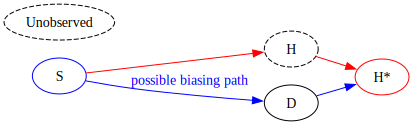

In [6]:
# Create a Digraph object
f = Digraph()
f.attr(rankdir='LR')  # Set graph direction from left to right
f.attr('node', shape='ellipse')  # Set default node shape to ellipse

# Node styles
f.node("S", color="blue")
f.node("H", style="dashed")  # Dashed style for node H
f.node("H*", color="red")
f.node("D", color="black")
f.node("Unobserved", color="black", style="dashed")

# Edge properties
f.edge("S", "H", color="red")  # Red edge from S to H
f.edge("H", "H*", color="red")  # Red edge from H to H*
f.edge("D", "H*", color="blue")  # Blue edge from D to H*
f.edge("S", "D", color="blue", label="possible biasing path", fontcolor="blue")  # Blue edge from S to D with label
f

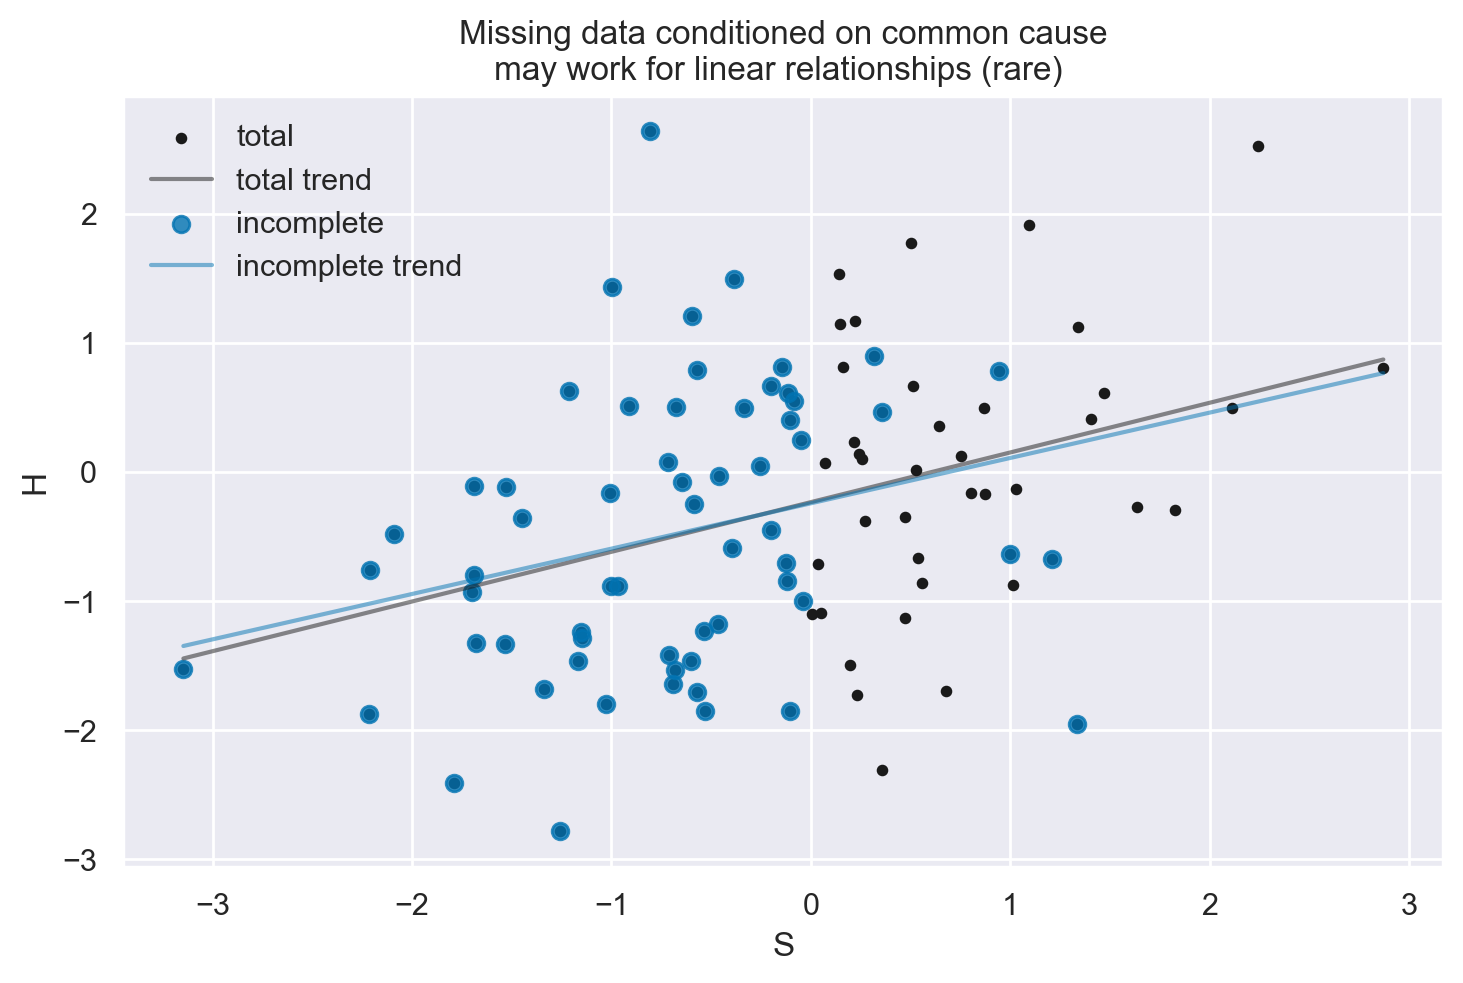

In [7]:
np.random.seed(12)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Linear association between student ability and homework score
mu_score = S * 0.5
H = stats.norm.rvs(mu_score)

# Dog eats based on the student's ability
p_dog_eats_homework = np.where(S > 0, 0.9, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data conditioned on common cause\nmay work for linear relationships (rare) ")

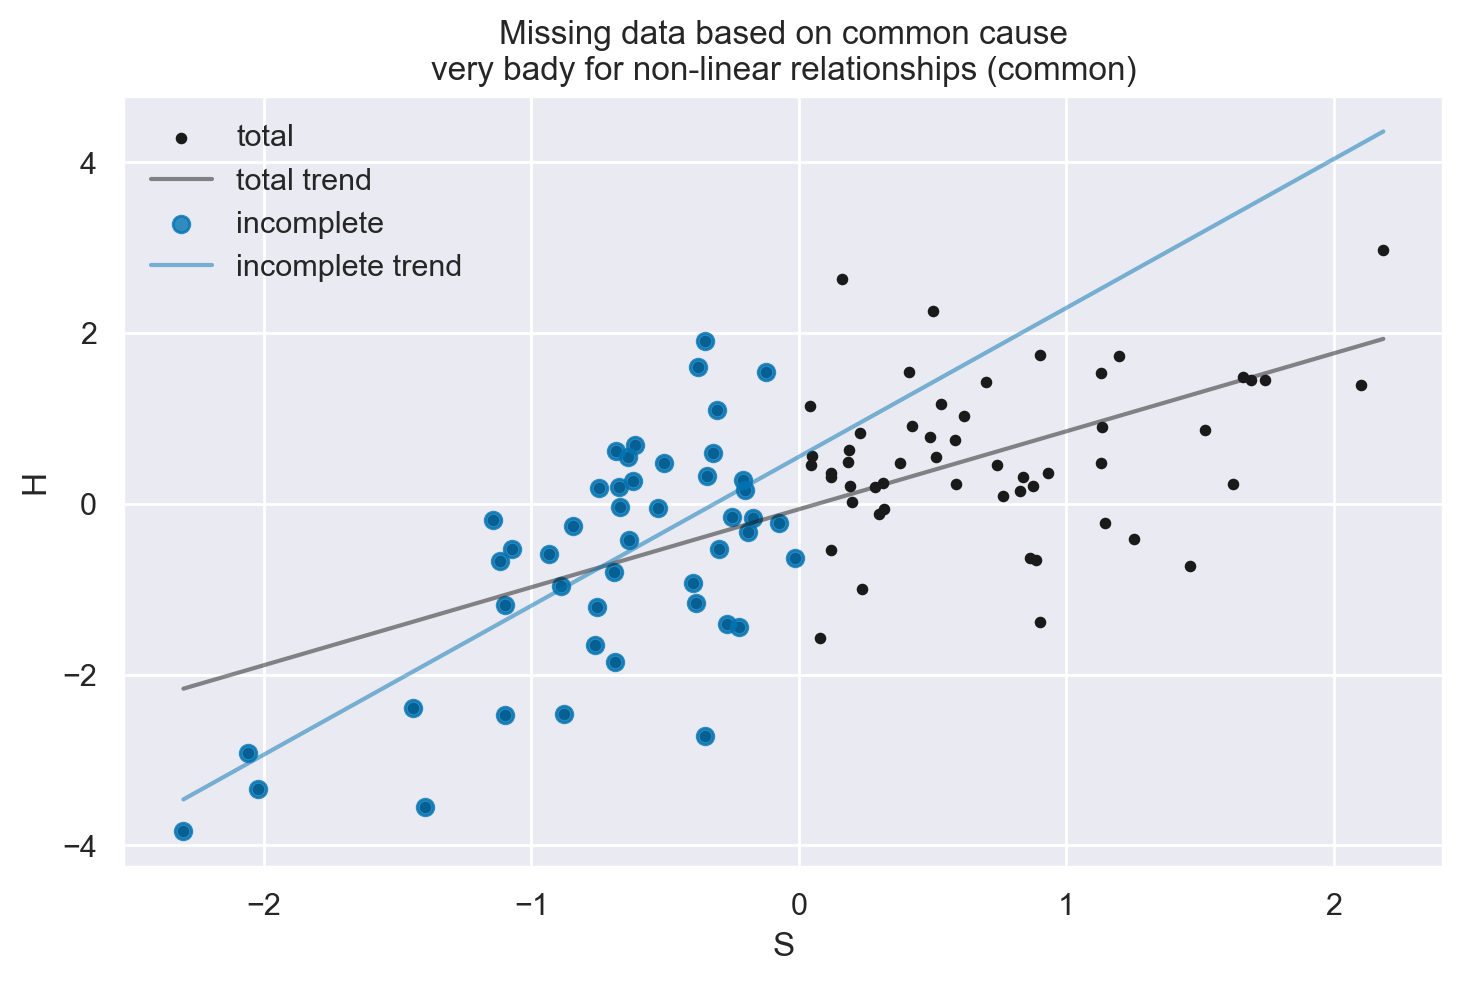

In [8]:
np.random.seed(1)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Nonlinear association between student ability and homework score
mu_score = 1 - np.exp(-0.7 * S)
H = stats.norm.rvs(mu_score)

# Dog eats all the homework of above-average students
p_dog_eats_homework = np.where(S > 0, 1, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data based on common cause\nvery bady for non-linear relationships (common)")

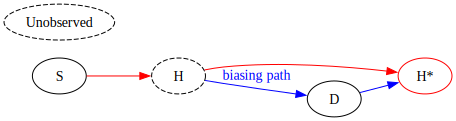

In [9]:
# Create a Digraph object
f = Digraph()
f.attr(rankdir='LR')  # Set graph direction from left to right
f.attr('node', shape='ellipse')  # Set default node shape to ellipse

# Node styles
f.node("H*", color="red")
f.node("H", style="dashed")  # Dashed style for node H
f.node("S", color="black")  # Default color for nodes
f.node("D", color="black")  # Default color for nodes
f.node("Unobserved", color="black", style="dashed")

# Edge properties
f.edge("S", "H", color="red")  # Red edge from S to H
f.edge("H", "H*", color="red")  # Red edge from H to H*
f.edge("H", "D", color="blue", label="biasing path", fontcolor="blue")  # Blue edge from H to D with label
f.edge("D", "H*", color="blue")  # Blue edge from D to H*

# Render the graph to a file (optional)
f


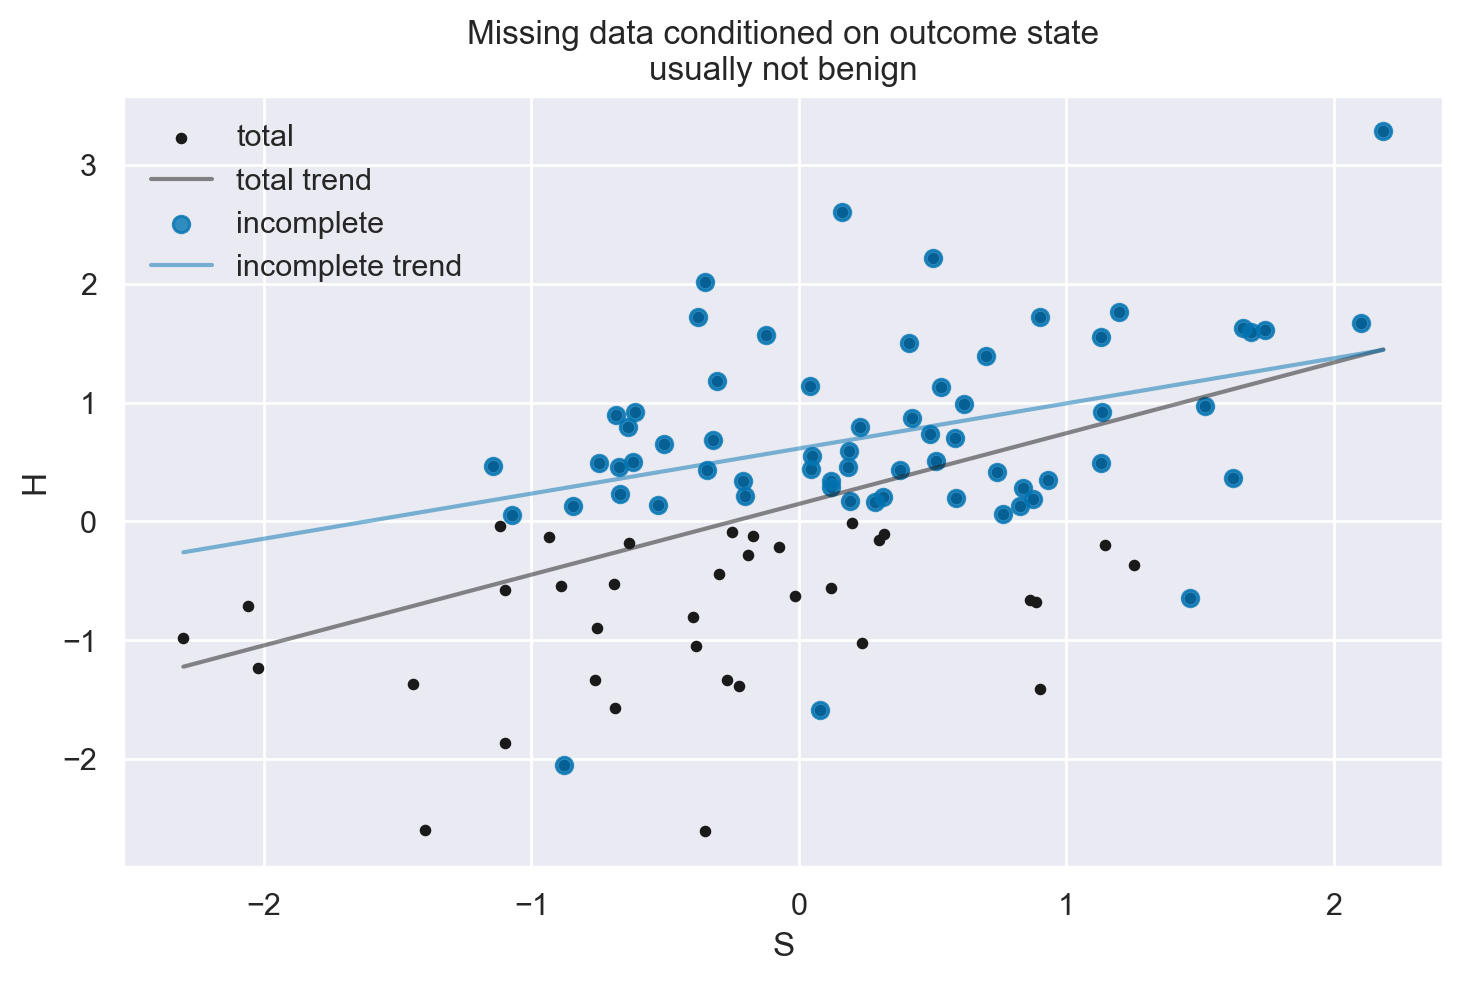

In [10]:
np.random.seed(1)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Linear association between ability and score
mu_score = S * 0.5
H = stats.norm.rvs(mu_score)

# Dog eats 90% of homework that is below average
p_dog_eats_homework = np.where(H < 0, 0.9, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data conditioned on outcome state\nusually not benign")

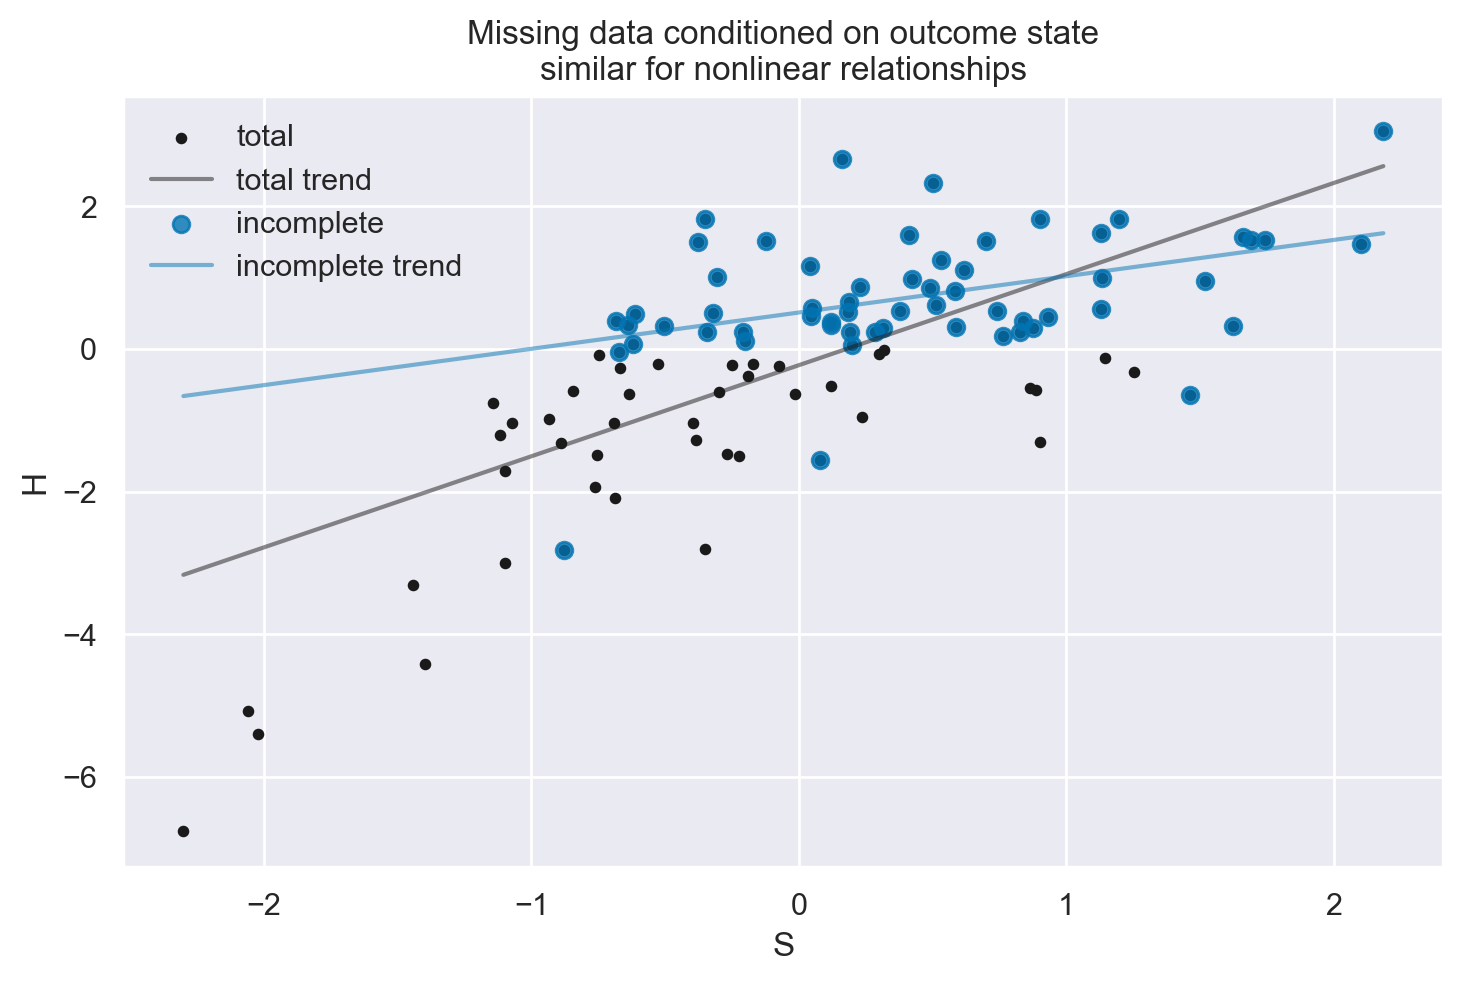

In [11]:
np.random.seed(1)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Nonlinear association between student ability and homework score
mu_score = 1 - np.exp(-0.9 * S)
H = stats.norm.rvs(mu_score)

# Dog eats 90% of homework that is below average
p_dog_eats_homework = np.where(H < 0, 0.9, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data conditioned on outcome state\nsimilar for nonlinear relationships")


L'analisi dei dati mancanti e la loro gestione possono avere implicazioni significative nell'interpretazione dei risultati di uno studio. Riflettiamo sui vari casi di dati mancanti che hai descritto, usando l'esempio metaforico del "cane che mangia i compiti" e collegandoli agli esempi precedenti di grafici causali (DAG):

### 1. Perdita di Dati Casuale e Indipendente dalle Cause
- **Esempio**: "Il cane mangia i compiti in modo casuale".
- **Conseguenze**: In questo caso, la perdita di dati è considerata "Missing Completely At Random" (MCAR). L'assenza di dati non è correlata né alle variabili osservate né a quelle non osservate.
- **Gestione**: È possibile escludere i casi completi senza introdurre bias, ma questo potrebbe portare a una perdita di efficienza (riduzione della dimensione del campione).
- **Ricollegamento ai DAG**: In un DAG, se la perdita di dati è indipendente da qualsiasi nodo, questo non altera le relazioni causali tra le variabili.

### 2. Perdita di Dati Condizionata dalla Causa
- **Esempio**: "Il cane mangia i compiti basandosi sulle abitudini di studio dello studente".
- **Conseguenze**: Questa situazione è classificata come "Missing At Random" (MAR). La probabilità di perdita di dati è correlata a variabili osservate.
- **Gestione**: È necessario condizionare correttamente sulla causa durante l'analisi per evitare distorsioni. Tecniche come la modellazione statistica che tiene conto delle variabili correlate alla perdita di dati possono essere utili.
- **Ricollegamento ai DAG**: Se la perdita di dati è legata a una variabile causale nel DAG, dobbiamo assicurarci di considerare questa variabilità durante l'analisi.

### 3. Perdita di Dati Condizionata dal Risultato
- **Esempio**: "Il cane mangia i compiti basandosi sul punteggio dei compiti".
- **Conseguenze**: Questa è una situazione di "Missing Not At Random" (MNAR). La perdita di dati è correlata al risultato mancante stesso, il che rende la situazione più complessa.
- **Gestione**: Spesso è difficile da gestire senza modellare il processo causale che determina la perdita di dati (es. comportamento del cane). Tecniche come l'analisi di sopravvivenza e i dati censurati possono essere applicate.
- **Ricollegamento ai DAG**: In un DAG, se la perdita di dati è correlata all'esito, potrebbe essere necessario modellare esplicitamente questa relazione per comprendere le implicazioni.

In sintesi, la gestione dei dati mancanti dipende dalla loro relazione con le variabili nel modello causale. Comprendere la natura della perdita di dati è fondamentale per selezionare l'approccio analitico appropriato e per interpretare accuratamente i risultati dello studio.